# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Вторая лабораторная работа </center>
# <center> Анализ сигналов </center>

In [250]:
import librosa
import numpy as np
import scipy
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib

# Запретим numpy выполнять деление на 0
np.seterr(divide='raise', invalid='raise')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [251]:
# Определим две функции для отрисовки сигнала.
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    # Replace 'waveplot' with 'waveshow'
    librosa.display.waveshow(wav, sr=sr)

def draw_sig(frames, name=None, figsize=(14, 3)):
    # Отрисовка сигнала в виде "леденцов на палочке"
    plt.figure(figsize=figsize)
    plt.stem(frames)
    if name is not None:
        plt.legend([name])
    plt.xlabel("n")
    plt.ylabel("Energy")
    plt.show()


Создадим несколько простых сигналов. Они нам понадобятся для дальшейшего тестирования

In [252]:
signals = {}

### Единичный импульс

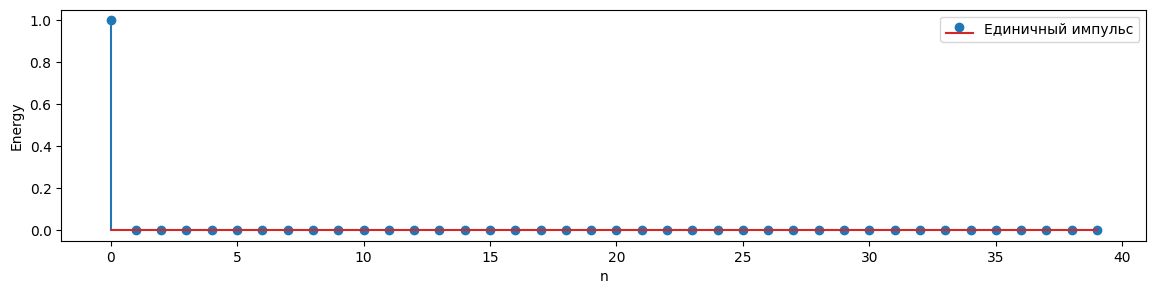

In [253]:
name = "Единичный импульс"
signals[name] = np.array([1] + [0]*39, dtype=float)
draw_sig(signals[name], name)

### Единичный скачок

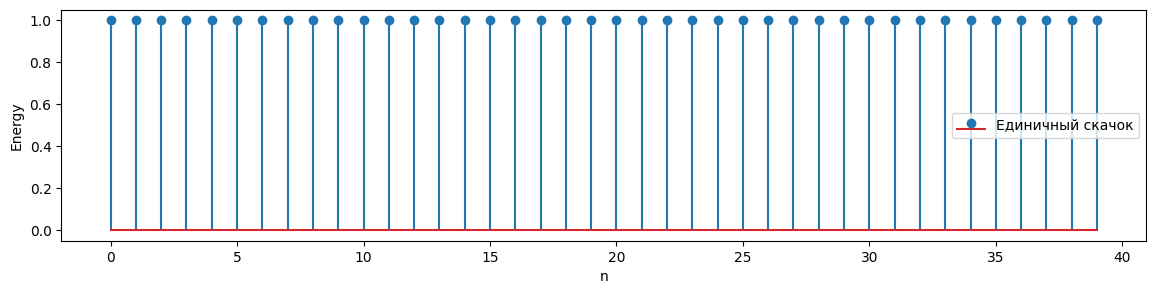

In [254]:
name = "Единичный скачок"
signals[name] = np.array([1]*40 ,dtype=float)
draw_sig(signals[name], name)

### Синус

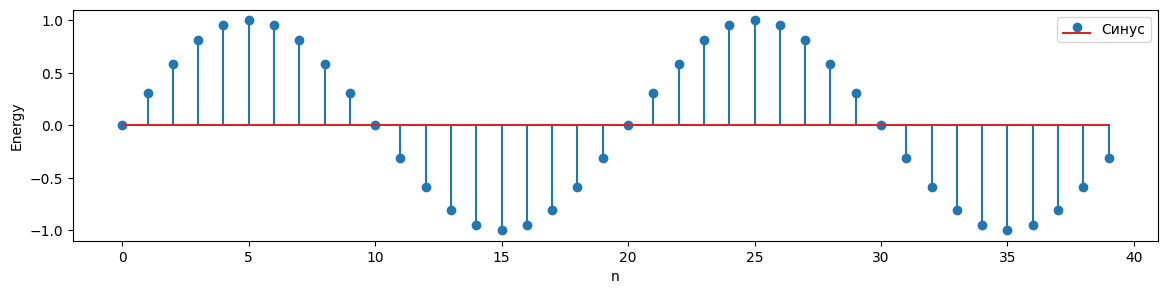

In [255]:
name = "Синус"
signals[name] = np.sin(np.pi * np.arange(40)/10)
draw_sig(signals[name], name)

### Шум

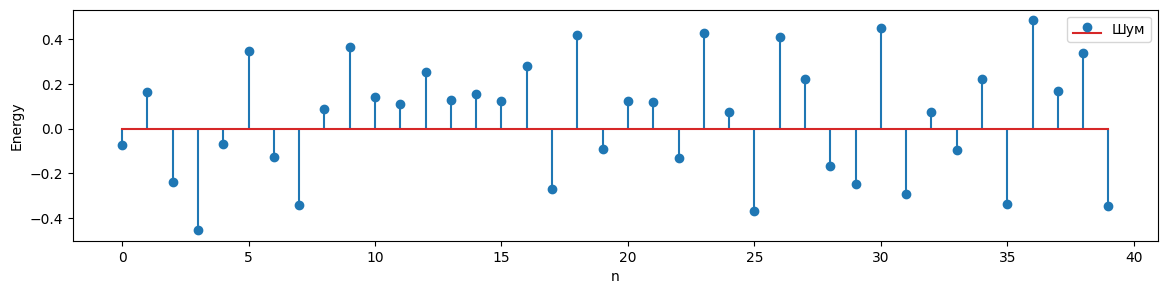

In [256]:
name = "Шум"
signals[name] = np.random.random(40)-0.5
draw_sig(signals[name], name)

-------------------------------
# Преобразование Фурье
Прежде, чем перейти к анализу сигналов, надо разобраться, что такое преобразование Фурье.
> Преобразование Фурье (символ ℱ) — операция, сопоставляющая одной функции вещественной переменной другую функцию вещественной переменной. Эта новая функция описывает коэффициенты («амплитуды») при разложении исходной функции на элементарные составляющие — гармонические колебания с разными частотами (подобно тому, как музыкальный аккорд может быть выражен в виде суммы музыкальных звуков, которые его составляют). [Wiki](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A4%D1%83%D1%80%D1%8C%D0%B5)



Формула прямого дискретного преобразования Фурье (ДПФ, Discrete Fourier Transform, DFT):
$$ X_k = \sum_{n=0}^{N-1} x_{n} \cdot e^{-i \frac{2\pi}{N} k n} $$


# Задание 1 (2 балла)
Реализовать дискретное преобразование Фурье. Сравнить с реализацией *scipy.fft.fft*

In [257]:
def DFT(x):
    N = len(x)
    X = np.zeros(N, dtype=complex)
    for k in range(N):
        for n in range(N):
            X[k] += x[n] * np.exp(-2j * np.pi * k * n / N)
    return X


    raise NotImplementedError()

Сравнение с библиотекой scipy

In [258]:
def test_DTF(x, transform=DFT):
    scipy_result = scipy.fft.fft(x)
    curr_result = transform(x)
    if scipy_result.shape != curr_result.shape:
        print("TEST_FAILED")
        print(f"Your spectrogram shape is {curr_result.shape}. "
              f"Scipy spectrogram shape is {scipy_result.shape}")
        return -1
    if not np.allclose(curr_result, scipy_result):
        print("TEST FAILED")
        print(f"scipy spectrogram: {scipy_result}")
        print(f"Your DTF spectrogram: {curr_result}")
        print(f"Average diff is {np.mean(np.abs(scipy_result - curr_result))}")
        return -2
    print("TEST PASSED")
    return 0

for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


Класическое ДПФ имеет существенный недостаток - сложность алгоритма $O(N^2)$. На данный момент существуют чуть более сложные реализации преобразования Фурье, которые избавляются от квадратичной сложности. Например, алгоритм быстрого преобразования Фурье (Fast Fourier Transform, FFT) имеет сложность $O(N log(N))$, что делает его значительно более быстрым на длинных последовательностях.

# Задание 1.1* (1 балл)
Реализовать быстрое преобразование Фурье. Сравнить с scipy.fft.fft

**Подсказка:** учтите, что для БПФ нам нужно, чтобы количество отсчетов сигнала было степенью двойки

In [259]:
def next_power_of_two(n):
    """Возвращает ближайшую степень двойки больше или равную n."""
    return 1 << (n - 1).bit_length()

def FFT(x):
    """Вычисляет быстрое преобразование Фурье."""
    N = len(x)

    # Если длина сигнала - 1, возвращаем его
    if N <= 1:
        return x

    # Разделяем сигнал на четные и нечетные элементы
    even = FFT(x[0::2])
    odd = FFT(x[1::2])

    # Объединяем результаты
    T = np.array([np.exp(-2j * np.pi * k / N) * odd[k] for k in range(N // 2)])

    return np.concatenate([even + T, even - T])

def fft_with_padding(x):
    """Выполняет FFT с дополнением до ближайшей степени двойки."""
    original_length = len(x)
    padded_length = next_power_of_two(original_length)

    # Дополняем сигнал нулями
    padded_x = np.pad(x, (0, padded_length - original_length), mode='constant')

    return FFT(padded_x)[:original_length]  # Возвращаем только оригинальную длину



In [260]:
'''for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig, transform=fft_with_padding) == 0, "Check you implementation"
print("All ok!")'''

'for name, sig in signals.items():\n    print(f"Checking \'{name}\'")\n    assert test_DTF(sig, transform=fft_with_padding) == 0, "Check you implementation"\nprint("All ok!")'

Если вы изменяли длительность исходных сигналов, не забудьте вернуть их изначальную длительность

In [261]:
# YOUR CODE HERE

# Амплитудный и фазовый спектры
Поскольку преобразование Фурье определено в комплекстной области, анализировать результат напрямую проблематично. Для анализа сигналов принято разбивать результат преобразования Фурье на два спектра: амплитудный и фазовый. Амплитудный показывает, как меняется модуль сигнала, а фазовый - как меняется угол, образуемый на комплексной плоскости.
# Задание 2 (1 балл)

Реализовать функции построения амплитудного и фазового спектра

In [262]:
#функция построения амплитудного спектра
def get_amplitude_from_spec(spec):
    amplitude = np.abs(spec)
    return amplitude


    raise NotImplementedError()

#функция построения фазового спектра
def get_phi_from_spec(spec):
    phase = np.angle(spec)  # Аргумент (угол) комплексных чисел
    return phase


    raise NotImplementedError()

In [263]:
def check_mean_var(sig, mean=None, var=None):
    if mean is not None and np.mean(sig) != mean:
        print(f"Bad mean. Expected {mean}, got {np.mean(sig)}")
        return False
    if var is not None and np.var(sig) != var:
        print(f"Bad var. Expected {var}, got {np.var(sig)}")
        return False
    return True

_spec = scipy.fft.fft(np.array([1]+[0]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 0.0), \
    "Wrong Amplitude"
assert check_mean_var(get_phi_from_spec(_spec), 0.0, 0.0), \
    "Wrong Phase"


_spec = scipy.fft.fft(np.array([1]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 9.0), \
    "Wrong  Amplitude"
assert get_amplitude_from_spec(_spec)[0] == 10, \
    "Wrong Amplitude"
assert get_phi_from_spec(_spec)[0] == 0, \
    "Wrong phase"

_spec = scipy.fft.fft(scipy.fft.ifft(np.array([0] + [10+5j]+[0]*6 + [10-5j])))
assert get_amplitude_from_spec(_spec).round(1)[1] == 11.2 , \
    "Wrong Amplitude. Make sure it is a complex number module."
assert get_phi_from_spec(_spec).round(1)[1] == 0.5 , \
    "Wrong Amplitude. Make sure it is an angle."


print("All OK!")

All OK!


Определим еще одну функцию для отрисовки. Теперь будем рисовать сигнал в частотной области

In [264]:
def draw_spec(spec, name=None, draw_A=True, draw_p=True, figsize=(14, 3)):
    if len(spec)<100:
        # Рисуем точки как "леденцы на палочках"
        draw_func = plt.stem
    else:
        # При большом N "леденцы" выглядят плохо,
        # Поэтому будем рисовать огибающую функцию
        draw_func = plt.plot

    if draw_A:
        plt.figure(figsize=figsize)
        plt.title("Amplitude spectrum")
        spec_A = get_amplitude_from_spec(spec)
        draw_func(spec_A)
        plt.ylabel("Magnitude")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()

    if draw_p:
        plt.figure(figsize=figsize)
        plt.title("Phase spectrum")
        phi = get_phi_from_spec(spec)
        draw_func(phi)
        plt.ylabel("Radian")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
    return

# Задание 2.1 (0.5 балла)
Постройте спектры для всех сигналов из коллекции signals и ответьте на вопросы:
<!-- 1. Почему амплитуда всех гармоник единичного импульса равна единице?
1. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый?
1. Как перевести номер отсчета в частоту?  
1. Что в фазовом спектре является полезной информацией, а что - шумом? Почему? -->

### Визуализация:

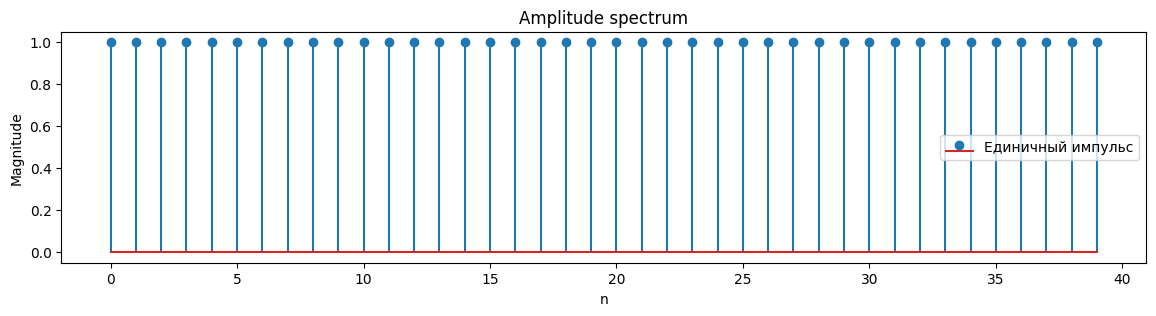

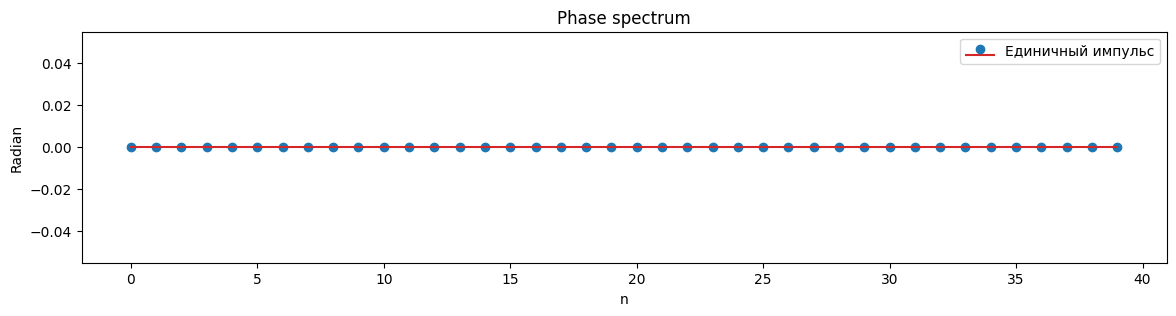

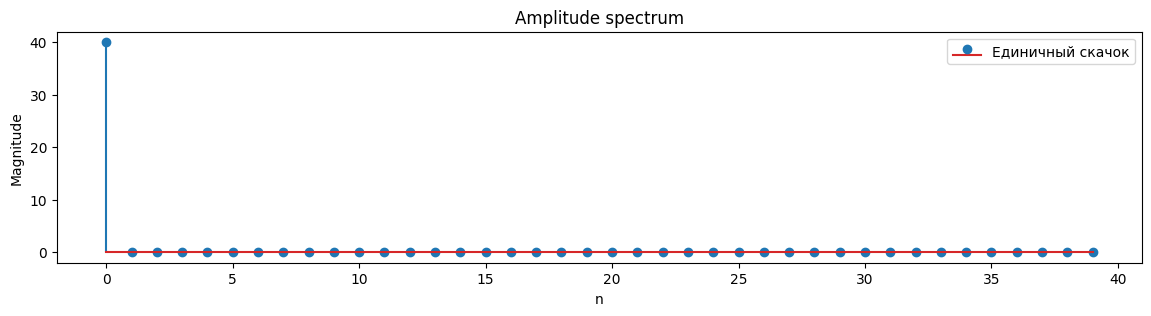

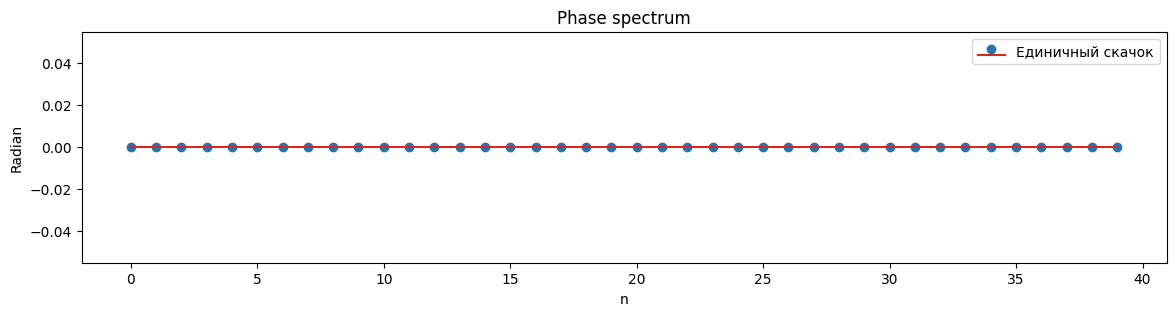

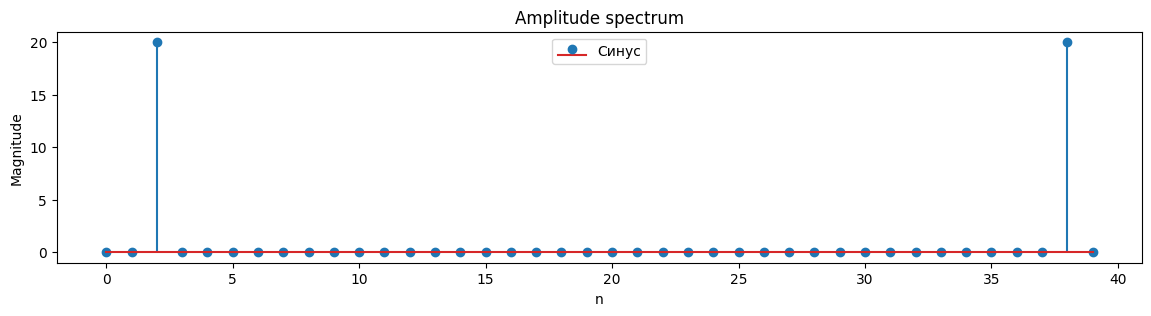

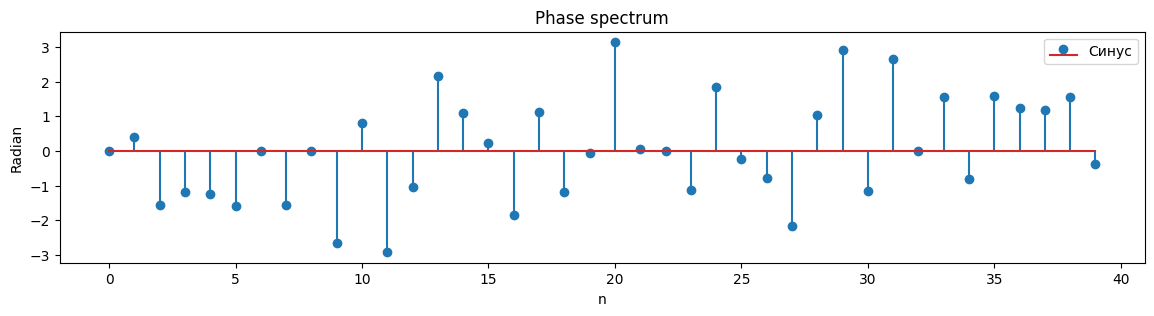

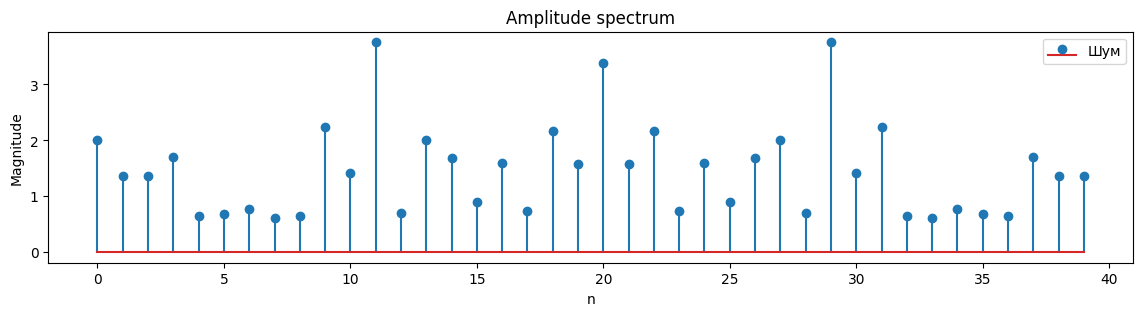

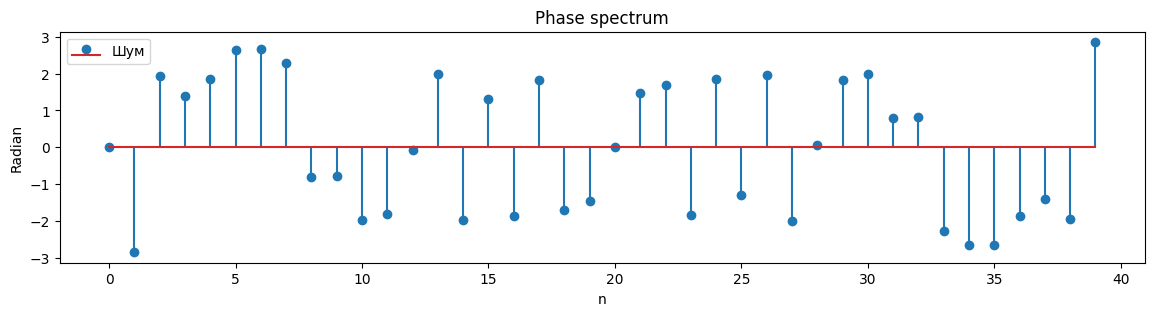

In [265]:
# YOUR CODE HERE
for name, signal in signals.items():
    spec = np.fft.fft(signal)
    draw_spec(spec, name=name)

### 1.Почему амплитуда всех гармоник единичного импульса равна константе?

In [266]:
# YOUR ANSWER HERE
#Когда мы говорим о единичном импульсе (дельта-функции), мы имеем в виду сигнал, который "щелкает" мгновенно и возвращается к нулю.
#значит:
#1. Все частоты присутствуют: Единичный импульс содержит все возможные частоты — от самых низких до самых высоких.
#2. Одна и та же амплитуда: Для каждой из этих частот амплитуда (или сила сигнала) равна 1.

### 2. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый?

In [267]:
# YOUR ANSWER HERE
'''
Амплитудный спектр

1. Частоты: Амплитудный спектр показывает, какие частоты присутствуют в сигнале. Пики в спектре указывают на доминирующие частоты.

2. Энергия сигнала: Чем выше амплитуда на определенной частоте, тем больше энергии сигнал содержит на этой частоте.

3. Ширина спектра: Широкий спектр может указывать на сложный сигнал с множеством частот (например, шум), тогда как узкий спектр может указывать на более простые, периодические сигналы.

4. Форма сигнала: Некоторые формы сигналов (например, синусоидальные) будут иметь характерные пики в амплитудном спектре.

Фазовый спектр

1. Фаза: Фазовый спектр показывает, как фаза каждой частоты изменяется относительно времени. Это важно для восстановления временной формы сигнала.

2. Синусоидальные компоненты: Фаза определяет, как каждая синусоидальная компонента будет складываться в результирующий сигнал. Это влияет на временные характеристики сигнала.

3. Интерференция: Различия в фазах могут приводить к интерференции между компонентами сигнала, что может усиливать или ослаблять определенные частоты.

4. Сложность сигнала: Если фаза изменяется сильно и непредсказуемо, это может указывать на сложный или нестабильный сигнал.'''

'\nАмплитудный спектр\n\n1. Частоты: Амплитудный спектр показывает, какие частоты присутствуют в сигнале. Пики в спектре указывают на доминирующие частоты.\n\n2. Энергия сигнала: Чем выше амплитуда на определенной частоте, тем больше энергии сигнал содержит на этой частоте.\n\n3. Ширина спектра: Широкий спектр может указывать на сложный сигнал с множеством частот (например, шум), тогда как узкий спектр может указывать на более простые, периодические сигналы.\n\n4. Форма сигнала: Некоторые формы сигналов (например, синусоидальные) будут иметь характерные пики в амплитудном спектре.\n\nФазовый спектр\n\n1. Фаза: Фазовый спектр показывает, как фаза каждой частоты изменяется относительно времени. Это важно для восстановления временной формы сигнала.\n\n2. Синусоидальные компоненты: Фаза определяет, как каждая синусоидальная компонента будет складываться в результирующий сигнал. Это влияет на временные характеристики сигнала.\n\n3. Интерференция: Различия в фазах могут приводить к интерфере

### 3. Как перевести номер отсчета в частоту?

In [268]:
# YOUR ANSWER HERE


# Параметры
fs = 1000  # Частота дискретизации в Гц
N = 1024   # Количество отсчетов

# Вычисление частот
frequencies = np.arange(N) * fs / N

print(frequencies)

[0.00000000e+00 9.76562500e-01 1.95312500e+00 ... 9.97070312e+02
 9.98046875e+02 9.99023438e+02]


Если у вас есть:

- \\( f_s \\) — частота дискретизации (в Гц),
- \\( N \\) — количество отсчетов (длина FFT),
- \\( k \\) — номер отсчета (индекс в результате FFT),

то частота, соответствующая индексу \\( k \\), вычисляется по формуле:


\\( f_k = \frac{k \cdot f_s}{N}\\)



### 4. Что в фазовом спектре является полезной информацией, а что - шумом? Почему?

In [269]:
# YOUR ANSWER HERE
'''В фазовом спектре полезной информацией являются четкие, устойчивые пики,
которые указывают на присутствие определенных частот или гармоник.
Шумом считаются случайные колебания и мелкие флуктуации без четкой структуры,
которые затрудняют анализ и могут скрывать полезные сигналы.

Полезная информация позволяет делать выводы о системе,
тогда как шум мешает этому процессу.'''

'В фазовом спектре полезной информацией являются четкие, устойчивые пики, \nкоторые указывают на присутствие определенных частот или гармоник. \nШумом считаются случайные колебания и мелкие флуктуации без четкой структуры, \nкоторые затрудняют анализ и могут скрывать полезные сигналы. \n\nПолезная информация позволяет делать выводы о системе, \nтогда как шум мешает этому процессу.'

# Оконное преобразование Фурье
Преобразование Фурье делает переход из временной области в частотную, позволяя анализировать составляющие сигнал гармоники. Однако это не всегда удобно. В реальных сигналах зачастую составляющие их гармоники изменяются со временем. Например, каждая буква в слове имеет свой набор основных гармоник, и простое преобразование Фурье не сильно поможет нам определить, что было сказано. Для того, чтобы анализировать такие сигналы, обычно используется [Оконное преобразование Фурье](https://ru.wikipedia.org/wiki/Оконное_преобразование_Фурье). Такое преобразование позволяет анализировать гармоники сигнала в коротких промежутках времени и сохранить временную ось при построении спектрограммы.
# Задание 3 (2 балла)
Реализовать оконное преобразование Фурье (Short-time Fourier transform), пользуясь только библиотеками *numpy* и *scipy*. Сравнить с *librosa.stft*


In [270]:
from scipy.signal import get_window
def STFT(x, n_fft=2048, hop_length=512, window='hann'):
    # x - signal
    # n_fft - fft window size
    # hop_length - step size between ffts
    # window - window type. See scipy.signal.get_window
    # return spectrogram
    # Определяем длину сигнала
    # Определяем длину сигнала
    # Определяем длину сигнала
    signal_length = len(x)
    window_function = get_window(window, n_fft)

    # Calculate the number of columns, ensuring it's at least 1
    num_columns = 1 + (signal_length - n_fft) // hop_length
    if (signal_length - n_fft) % hop_length:
        num_columns += 1

    # Initialize the spectrogram array
    spectrogram = np.zeros((n_fft // 2 + 1, num_columns), dtype=np.complex128)

    # Center the signal for STFT similar to librosa's default behavior
    padding = n_fft // 2
    x_padded = np.pad(x, (padding, padding), mode='reflect')

    for i in range(num_columns):
        start = i * hop_length
        x_segment = x_padded[start : start + n_fft]
        x_segment *= window_function  # Apply windowing

        # Apply FFT to the segment
        spectrogram[:, i] = np.fft.rfft(x_segment)

    return spectrogram
    raise NotImplementedError()


In [271]:
def test_stft(x, n_fft=2048, hop_length=512, window='hann'):
    librosa_result = librosa.stft(x, n_fft=n_fft, hop_length=hop_length, window='hann', center=True)
    result = STFT(x, n_fft=n_fft, hop_length=hop_length, window='hann')
    if librosa_result.shape != result.shape:
        print(f"Your shape {result.shape} != librosa stft shape {librosa_result.shape} ")
        return -1
    if not np.allclose(librosa_result, result):
        print(f"Wrong results. Diff {np.abs(librosa_result-result)}")
        return -2
    return 0

for name, sig in signals.items():
    print(f"Checking '{name}'")
    for n_fft in (8, 4):
        for hop_length in (n_fft//4, n_fft//2):
            assert test_stft(sig, n_fft=n_fft, hop_length=hop_length)==0, \
                f"Test failed. Params n_fft {n_fft}. Hop_length {hop_length}"
    print("ok")
print("All ok!")

Checking 'Единичный импульс'
Your shape (5, 17) != librosa stft shape (5, 21) 


AssertionError: Test failed. Params n_fft 8. Hop_length 2

Определим функцию для отрисовки

In [272]:
# Определим функцию для отрисовки
def draw_stft(X, sr, figsize=(14, 5)):
    plt.figure(figsize=figsize)
    # X - комплекстная спектрограмма
    # Для получения энергии достаточно взять модуль
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.show()

# Анализ сигналов
Теперь можно приступить к анализу звуковых сигналов.
Во время анализа сигналов нам понадобятся все определенные выше инструменты.


----------------------------------
## Анализ паровозного гудка
Начнем с простого сигнала, состоящего из нескольких основных гармоник и шума.

Загрузим аудио файл с паровозным гудком

Len is 82175 ( ). Sample rate is 22050


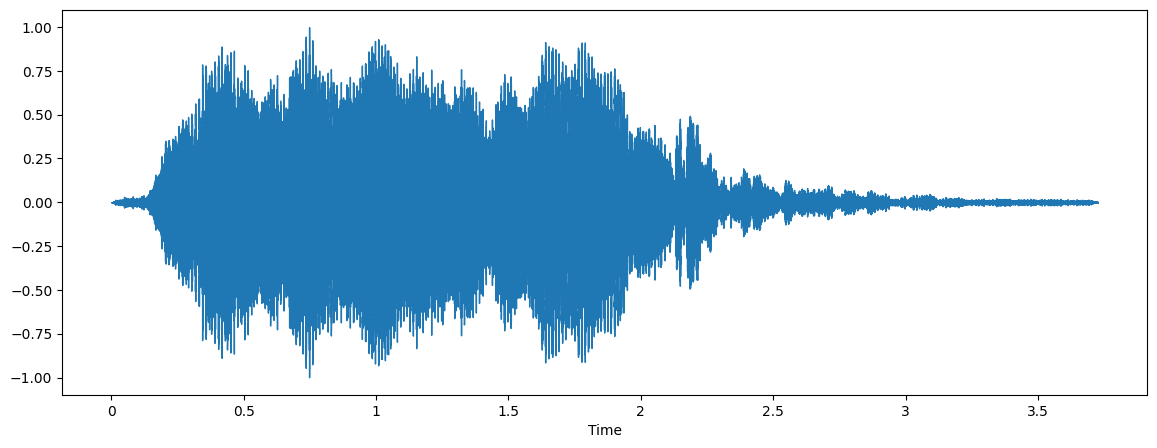

In [273]:
# Загрузим аудио файл с паровозным гудком
train_whistle, tw_sr = librosa.core.load("/content/train_whistle.wav")
print(f"Len is {len(train_whistle)} ( ). Sample rate is {tw_sr}")
player = ipd.Audio(train_whistle, rate=tw_sr)
ipd.display(player)
draw_waveform(train_whistle, sr=tw_sr)

Построим гудок паровоза в частотной области

Гудок паровоза в частотной области


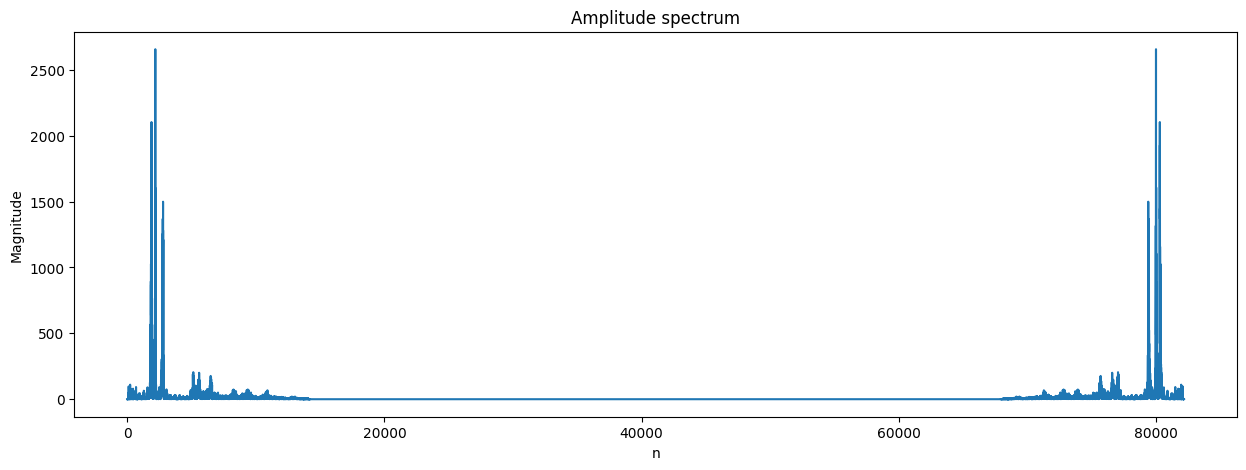

In [274]:
train_whistle_spec = scipy.fft.fft(train_whistle)
print("Гудок паровоза в частотной области")
draw_spec(train_whistle_spec, draw_p=False, figsize=(15,5))

# Задание 4 (2 балла)
Определите 3 основные гармоники паровозного гудка.

Ответ округлите до двух знаков после запятой.


Амплитудный спектр

Амплитудный спектр


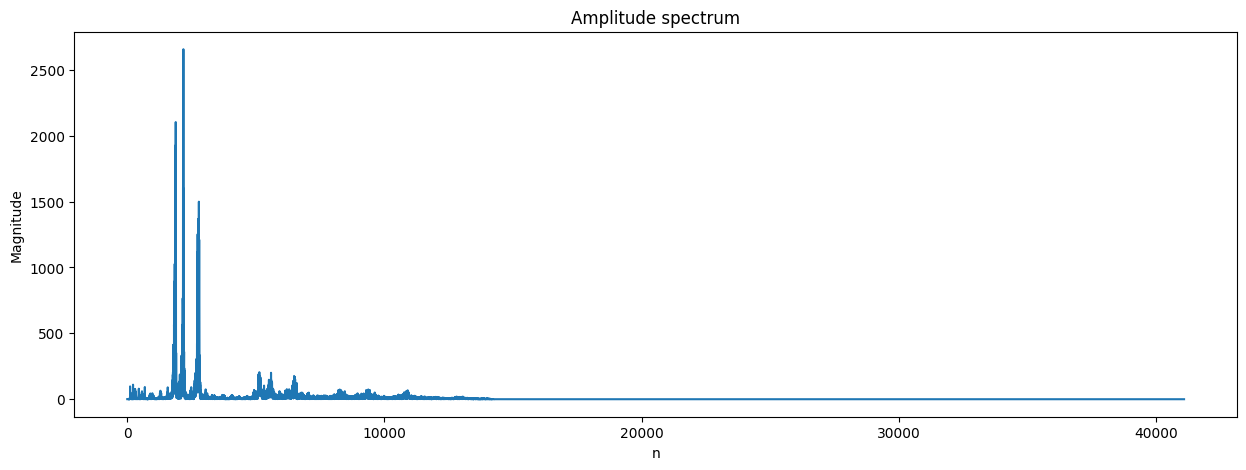

In [301]:
# YOUR CODE HERE

from scipy.fft import fft, fftfreq
N = len(train_whistle)  # Длина сигнала
T = 1.0 / tw_sr         # Период дискретизации

# Преобразование Фурье
train_whistle_spec = fft(train_whistle)

# Получаем частоты
xf = fftfreq(N, T)[:N//2]

# Получаем амплитуды
amplitude_spectrum = np.abs(train_whistle_spec)[:N//2]
print("Амплитудный спектр")
draw_spec(amplitude_spectrum, draw_p=False, figsize=(15,5))


### 1 гармоника

In [303]:
# YOUR CODE HERE
# Находим пики в амплитудном спектре
peaks_indices = amplitude_spectrum.argsort()[-3:][::-1]  # Индексы трех наибольших пиков
harmonics_frequencies = xf[peaks_indices]

# Округляем до двух знаков после запятой
harmonics_frequencies_rounded = np.round(harmonics_frequencies, 2)

# Выводим результаты
for i, freq in enumerate(harmonics_frequencies_rounded, start=1):
    print(f"{i} гармоника: {freq} Гц")


1 гармоника: 585.76 Гц
2 гармоника: 584.69 Гц
3 гармоника: 584.96 Гц


### 2 гармоника

In [294]:
# YOUR CODE HERE
print(harmonics_frequencies_rounded[1])

584.69


### 3 гармоника

In [295]:
# YOUR CODE HERE
print(harmonics_frequencies_rounded[2])

584.96


### Тест

In [304]:
# task_answer = [ freq1, freq2, freq3 ]
task_answer = harmonics_frequencies_rounded

In [305]:
assert type(task_answer) == list or type(task_answer) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(task_answer)}"
assert len(task_answer) == 3, \
        f"Wrong len {len(task_answer)}."
assert (round(sum(task_answer)) == 1677 and round(np.var(task_answer)) == 1407) or \
        (abs(sum(task_answer)  - 1836) <= 3 and abs(np.var(task_answer) - 10153) <= 181), \
        f"Wrong freqs"
print("Correct!")

AssertionError: Wrong freqs

Теперь попробуйте сгенерировать сигнал, состоящий только из этих гармоник. Воспроизведите сигнал.

In [ ]:
#YOUR CODE HERE

# Анализ двухтонального многочастотного сигнала
Теперь расмотрим более сложный сигнал - [DTMF](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling). Такие сигналы используются для автоматизации набора телефонного номера.

# Задание 5 (2 балла)
В данном аудио закодирован трехзначный номер. Используя таблицу с [wiki]:(https://ru.wikipedia.org/wiki/DTMF) определите, что за номер закодирован.


Визуализация

Len is 243102. Sample rate is 22050


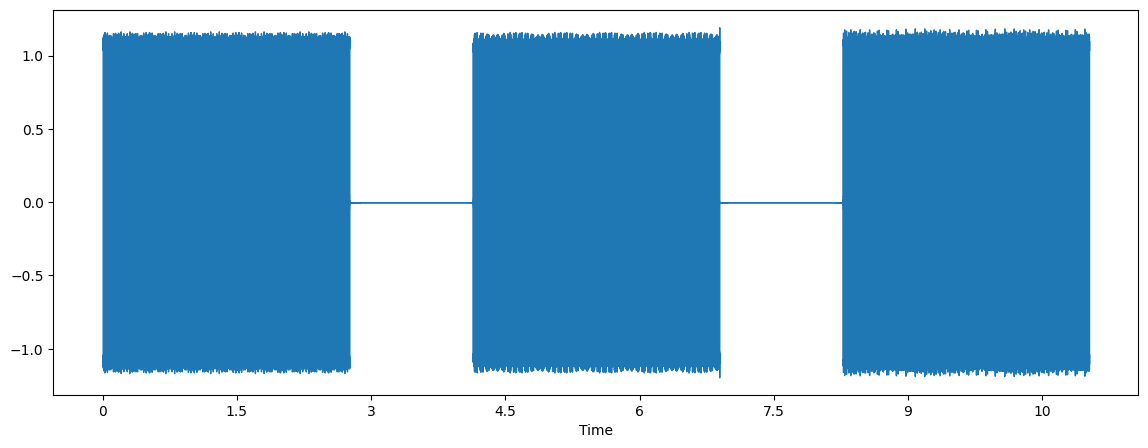

In [308]:
#dtmf.wav
dtmf, dtmf_sr = librosa.core.load("/content/dtmf.wav")
print(f"Len is {len(dtmf)}. Sample rate is {dtmf_sr}")
player = ipd.Audio(dtmf, rate=dtmf_sr)
ipd.display(player)
draw_waveform(dtmf, sr=dtmf_sr)

In [328]:
N = len(dtmf)
yf = fft(dtmf)
xf = np.fft.fftfreq(N, 1/dtmf_sr)

# Получаем амплитуды и фильтруем по положительным частотам
amplitude_spectrum = np.abs(yf)[:N//2]
xf = xf[:N//2]

# Находим пики в амплитудном спектре
peaks_indices = amplitude_spectrum.argsort()[-3:][::-1]  # Находим 10 наибольших пиков
harmonics_frequencies = xf[peaks_indices]

# Выводим найденные частоты
print("Найденные частоты (Гц):", harmonics_frequencies)

Найденные частоты (Гц): [1477.00224597 1208.97586198  769.97494879]


### 1 число

In [329]:
# YOUR CODE HERE


# Таблица DTMF частот
dtmf_frequencies = {
    (697, 1209): '1', (697, 1336): '2', (697, 1477): '3', (697, 1633): 'A',
    (770, 1209): '4', (770, 1336): '5', (770, 1477): '6', (770, 1633): 'B',
    (852, 1209): '7', (852, 1336): '8', (852, 1477): '9', (852, 1633): 'C',
    (941, 1209): '*', (941, 1336): '0', (941, 1477): '#', (941, 1633): 'D'
}

# Определяем цифры по найденным частотам
detected_digits = []
for freq in harmonics_frequencies:
    for key in dtmf_frequencies.keys():
        if abs(freq - key[0]) < 20 or abs(freq - key[1]) < 20:  # Допустимая погрешность
            detected_digits.append(dtmf_frequencies[key])
            break

print(detected_digits[0])

3


### 2 число

In [330]:
# YOUR CODE HERE
print(detected_digits[1])

1


### 3 число

In [331]:
# YOUR CODE HERE
print(detected_digits[2])

4


### Тест

In [336]:
# phone_number = [first: int, second: int, third: int]
phone_number = list(map(int, detected_digits))

In [337]:
assert type(phone_number) == list or type(phone_number) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(phone_number)}"
assert len(phone_number) == 3, \
        f"Wrong len {len(phone_number)}."
assert round(np.mean(phone_number)) == 5 and round(np.var(phone_number)) == 11 , \
        f"Wrong number"
assert hashlib.md5(''.join(map(str, phone_number)).encode()).hexdigest() == "140f6969d5213fd0ece03148e62e461e", \
        f"Wrong hash. How did you pass mean/var test?"
print("Correct!")

AssertionError: Wrong number